In [1]:
from locations import location_output
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Analysis of fluxes produced by cancer epistasis algorithm for LUAD
### Purpose:
    1. To explain the WT -> KRAS flux bimodal distribution
    2. To understand why gain of TTN mutation was calculated to have an unusually high gamma
    3. To verify that aspects of the algorithm are performing as expected
    4. To sort through the results in order to retrieve genes of interest

#### Initialize Fluxes

In [2]:
#Load fluxes in 
#CURRENT STATE: PAN-DATA
all_fluxes = np.load(os.path.join(location_output, 'pan_data_fluxes_mles.npy'), allow_pickle=True).item()

In [3]:
def filter_to_xy(x, y, all_estimates):
    """Filter the estimates to only those from x to y"""
    return {gene:estimates[(x, y)]
            for gene, estimates in all_estimates.items()}

In [4]:
#obtain average TP53 and KRAS fluxes from WT
fluxes_TP53 = list(filter_to_xy((0,0,0), (1,0,0),all_fluxes).values())
fluxes_KRAS = list(filter_to_xy((0,0,0), (0,1,0),all_fluxes).values())

flux_TP53 = np.mean(fluxes_TP53)
flux_KRAS = np.mean(fluxes_KRAS)

#obtain fluxes for 3rd gene
#CURRENT STATE: from WT
fluxes = filter_to_xy((0,0,0), (0,0,1), all_fluxes)
fluxes['TP53'] = flux_TP53
fluxes['KRAS'] = flux_KRAS

## KRAS BIMODAL DISTRIBUTION

In [5]:
pd.DataFrame([fluxes_TP53, fluxes_KRAS]).transpose().rename(columns={0:'TP53',1:'KRAS'}).describe()

,TP53,KRAS
count,1082.000000,1082.000000
mean,0.683619,0.311054
std,0.014092,0.097807
min,0.581527,0.164954
25%,0.676397,0.218312
50%,0.689083,0.253424
75%,0.691381,0.415770
max,0.760649,0.577220


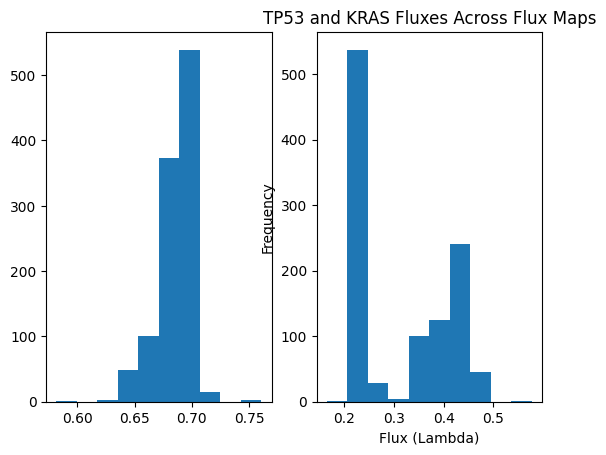

In [6]:
fig, axs = plt.subplots(1, 2)

axs[0].hist(fluxes_TP53)
axs[1].hist(fluxes_KRAS)

plt.title("TP53 and KRAS Fluxes Across Flux Maps")
plt.xlabel("Flux (Lambda)")
plt.ylabel("Frequency")

plt.show()

#### Does the same bimodal distribution occur for other fluxes?

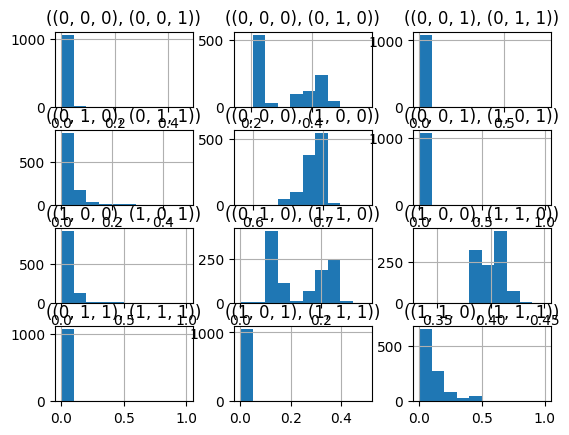

In [9]:
all_fluxes_df = pd.DataFrame.from_dict(all_fluxes, orient = 'index')
all_fluxes_df.hist()
plt.show()

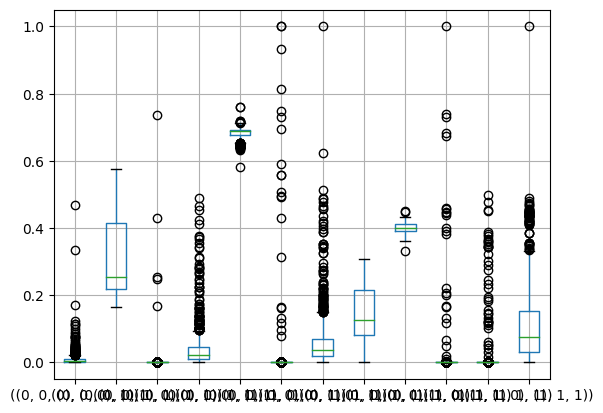

In [16]:
all_fluxes_df.boxplot()
plt.show()

Other than WT -> KRAS, KRAS -> KRAS + TP53 and TP53 -> TP53 + KRAS also have bimodal distribution. 
Interestingly, gain of KRAS only has a bimodal distribution from WT and TP53, not from 3rd gene or TP53 + 3rd, though it must be noted that those distributions are skewed so far right it is essentially impossible to see a bimodal distribution. It may be appropriate to assume that gain of KRAS is always associated with a bimodal distribution.

I am unsure why gain of TP53 from KRAS has such a strong bimodal distribution. Does it indicate some association between the fluxes where tumors belonging to one mode/type in WT -> KRAS consistently belong to a mode/type in KRAS -> KRAS + TP53?

#### Looking for significant differences within flux maps for each mode

In [6]:
gene_fluxes_TP53 = filter_to_xy((0,0,0), (1,0,0),all_fluxes)
gene_fluxes_KRAS = filter_to_xy((0,0,0), (0,1,0),all_fluxes)

KRAS_mode1_genes = [k for k,v in gene_fluxes_KRAS.items() if v <0.3]
KRAS_mode2_genes = [k for k,v in gene_fluxes_KRAS.items() if v >0.3]
#almost equivalent split, around 530 genes around both modes

In [7]:
#convert to pandas dictionary
KRAS_mode1 = {gene:all_fluxes[gene] for gene in KRAS_mode1_genes}
KRAS_mode1 = pd.DataFrame.from_dict(KRAS_mode1).transpose()

KRAS_mode2 = {gene:all_fluxes[gene] for gene in KRAS_mode2_genes}
KRAS_mode2 = pd.DataFrame.from_dict(KRAS_mode2).transpose()

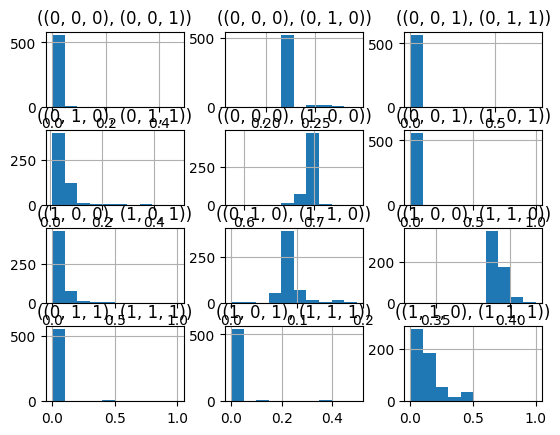

In [6]:
KRAS_mode1_hist = KRAS_mode1.hist()
plt.show()

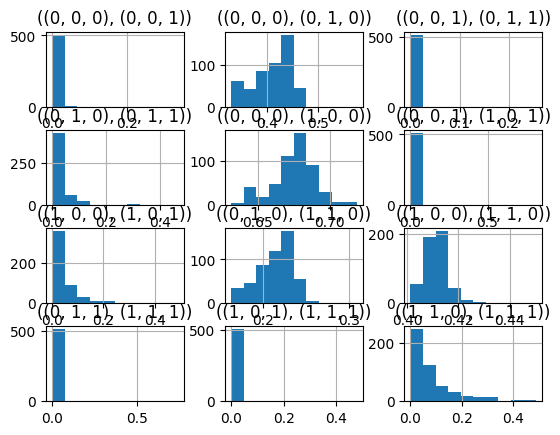

In [7]:
KRAS_mode2_hist = KRAS_mode2.hist()
plt.show()

Since the histograms for each individual mode does not show any bimodal distributions, this suggests that the bimodal distributions for TP53/KRAS -> TP53 + KRAS are likely caused by the same process that produces the WT -> KRAS bimodal distribution.

We can also note that the low mode for the WT -> KRAS distribution maps to the low mode of the other bimodal distributions, and same for the high mode.

In consideration of the low mode genes, most patients only gain KRAS post-TP53 mutation, no 3rd gene mutation. In consideration of the high mode genes, most patients gain KRAS both pre- and post-TP53 mutation but not post-3rd gene mutation.
So the only variable changing between the two distributions is the 3rd-gene mutation, but it doesn't appear to be directly responsible for anything. TP53 is gained slightly more commonly from WT for the low mode genes, which may explain why we see so many KRAS mutations post- rather than pre-TP53 mutation.
For the vast majority of these 3rd genes, we don't see their mutation frequently, so fluxes involving them are expected to be low in general.
**But why is it that amongst the genes there is a strong split where KRAS is infrequently gained from WT or twice as frequently gained from WT given that the 3rd genes' fluxes are low regardless (meaning that the gain of KRAS post-3rd gene mutation has an essentially null effect on the gain of KRAS anywhere else).**
Is the lack of mutation in those genes somehow indirectly linked to something else that we are not measuring that is responsible for causing a low flux of KRAS from WT? As in, I wonder if the set of other mutations that those patients have is not randomly distributed between the patients in the two modes, and the KRAS flux is affected by the epistatic effect of those mutations.

In [19]:
mode1_summary = KRAS_mode1.describe()
mode2_summary = KRAS_mode2.describe()

In [20]:
differences = mode2_summary.loc['mean'] - mode1_summary.loc['mean']
uncertainties = (mode2_summary.loc['std']**2 + mode1_summary.loc['std']**2)**(1/2)

In [21]:
#determine significant differences
print(differences / uncertainties)

(0, 0, 0)  (0, 0, 1)   -0.082150
           (0, 1, 0)    4.647193
(0, 0, 1)  (0, 1, 1)   -0.058000
(0, 1, 0)  (0, 1, 1)   -0.231264
(0, 0, 0)  (1, 0, 0)   -0.917747
(0, 0, 1)  (1, 0, 1)   -0.053937
(1, 0, 0)  (1, 0, 1)   -0.215553
(0, 1, 0)  (1, 1, 0)    4.190467
(1, 0, 0)  (1, 1, 0)    2.676446
(0, 1, 1)  (1, 1, 1)   -0.112605
(1, 0, 1)  (1, 1, 1)   -0.125394
(1, 1, 0)  (1, 1, 1)   -0.277076
dtype: float64


Based on this, in terms of fluxes other than WT -> KRAS, the average fluxes of the two modes are not different except for TP53 or KRAS -> TP53 + KRAS, which were previously established to be due to the same underlying cause, and maybe WT -> TP53.

#### Looking for possible associations between the bimodal KRAS distribution and the WT -> 3rd gene flux.

We already know that the KRAS fluxes are split into two groups by the 3rd gene (I believe it to be solely due to the 3rd gene though I wonder if there are higher level interactions that I am not accounting for). Now we need to determine what aspect of the 3rd gene could be causing the 2 modes.

If the flux of one state change is causing  the WT -> KRAS flux, then I expect to see some significant difference in the fluxes for that state change around one mode relative to another (e.g. the fluxes for the state change in question at mode 1 are significantly higher or lower than fluxes at mode 2). There does not need to be a notable linear trend of one flux with another, just a difference between the 2 modes.

In [8]:
KRAS_3rd_fluxes = dict()
for key in gene_fluxes_KRAS:
    KRAS_3rd_fluxes[key] = (gene_fluxes_KRAS[key], fluxes[key])
TP53_3rd_fluxes = dict()
for key in gene_fluxes_TP53:
    TP53_3rd_fluxes[key] = (gene_fluxes_TP53[key], fluxes[key])

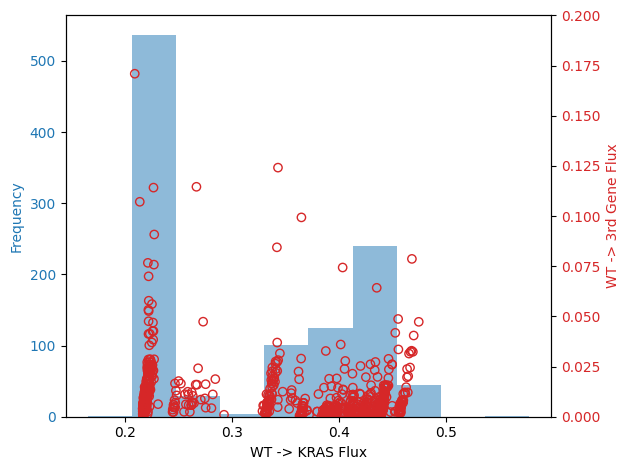

In [11]:
#x for KRAS, y for 3rd gene
x = []
y = []
for i in KRAS_3rd_fluxes.values():
    x.append(i[0])
    y.append(i[1])

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel("WT -> KRAS Flux")
ax1.set_ylabel('Frequency', color=color)  # we already handled the x-label with ax1
ax1.hist(fluxes_KRAS, alpha = 0.5, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel("WT -> 3rd Gene Flux", color=color)
ax2.scatter(x, y, color='none', edgecolor = color)
ax2.set_ylim(0, 0.2) #results in exclusion of 2 3rd gene flux outliers
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

There doesn't seem to be a strong distinguishing factor between the WT -> 3rd gene fluxes for the two modes.

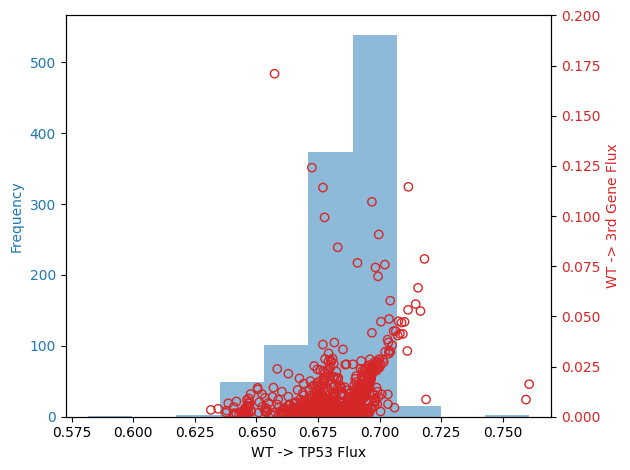

In [12]:
#x for TP53, y for 3rd gene
x = []
y = []
for i in TP53_3rd_fluxes.values():
    x.append(i[0])
    y.append(i[1])

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel("WT -> TP53 Flux")
ax1.set_ylabel('Frequency', color=color)  # we already handled the x-label with ax1
ax1.hist(fluxes_TP53, alpha = 0.5, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel("WT -> 3rd Gene Flux", color=color)
ax2.scatter(x, y, color='none', edgecolor = color)
ax2.set_ylim(0, 0.2) #results in eclusion of 2 3rd gene flux outliers, same as before
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

For TP53, there is a linear correlation of the two fluxes which just also happens to map pretty neatly to the frequency of the WT -> TP53 fluxes. I suppose that it may be an indication that the high flux TP53 + 3rd gene combos are more commonly observed in LUAD patients.

"Maybe certain genes drive KRAS and thus if we don't include them in the model the flux to KRAS has to account for that and is then larger" - Jorge

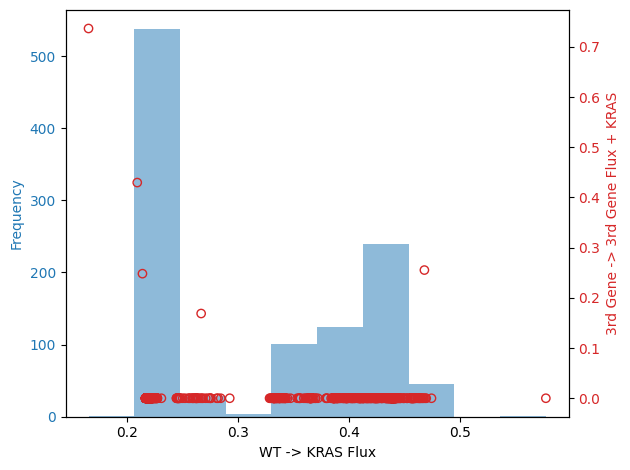

In [13]:
fluxes_mutant_KRAS = filter_to_xy((0,0,1), (0,1,1), all_fluxes)
fluxes_mutant_KRAS['TP53'] = flux_TP53
fluxes_mutant_KRAS['KRAS'] = flux_KRAS

KRAS_3rd_fluxes = dict()
for key in gene_fluxes_KRAS:
    KRAS_3rd_fluxes[key] = (gene_fluxes_KRAS[key], fluxes_mutant_KRAS[key])
    
#x for KRAS, y for 3rd gene
x = []
y = []
for i in KRAS_3rd_fluxes.values():
    x.append(i[0])
    y.append(i[1])

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel("WT -> KRAS Flux")
ax1.set_ylabel('Frequency', color=color)  # we already handled the x-label with ax1
ax1.hist(fluxes_KRAS, alpha = 0.5, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel("3rd Gene -> 3rd Gene Flux + KRAS", color=color)
ax2.scatter(x, y, color='none', edgecolor = color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [14]:
#exceptions to the ~0 flux for KRAS after 3rd gene mutation
[key for key,value in KRAS_3rd_fluxes.items() if value[1] > 0.1]

['STK11', 'ZFHX4', 'PCDHGA8', 'TTN', 'SPTA1']

In the vast majority of cases, the flux for gaining KRAS after 3rd gene is ~0.
In the few exceptions, they follow the bimodal distribution of KRAS. Not too sure if I can say anything from that.

Since this distribution is skewed so far right, it may be better to repeat this with TP53 + 3rd gene -> TP53 + 3rd gene + KRAS, which features a prominent bimodal distribution, with the assumption that TP53 has no variable effects on the distribution independent of whatever is causing the bimodal KRAS distribution. 

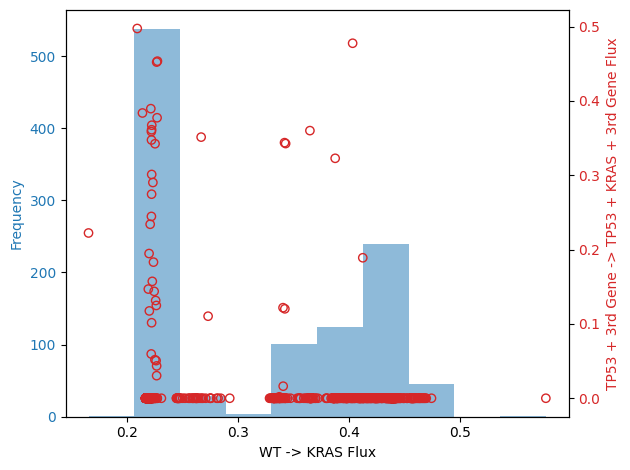

In [15]:
fluxes_mutant_KRAS = filter_to_xy((1,0,1), (1,1,1), all_fluxes)
fluxes_mutant_KRAS['TP53'] = flux_TP53
fluxes_mutant_KRAS['KRAS'] = flux_KRAS

KRAS_3rd_fluxes = dict()
for key in gene_fluxes_KRAS:
    KRAS_3rd_fluxes[key] = (gene_fluxes_KRAS[key], fluxes_mutant_KRAS[key])
    
#x for KRAS, y for 3rd gene
x = []
y = []
for i in KRAS_3rd_fluxes.values():
    x.append(i[0])
    y.append(i[1])

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel("WT -> KRAS Flux")
ax1.set_ylabel('Frequency', color=color)  # we already handled the x-label with ax1
ax1.hist(fluxes_KRAS, alpha = 0.5, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel("TP53 + 3rd Gene -> TP53 + KRAS + 3rd Gene Flux", color=color)
ax2.scatter(x, y, color='none', edgecolor = color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [28]:
#comparison of high flux genes between the two modes
print(len([k for k,v in fluxes_mutant_KRAS.items() if k in KRAS_mode1_genes and v > 0.001]))
print(len([k for k,v in fluxes_mutant_KRAS.items() if k in KRAS_mode2_genes and v > 0.001]))

33
10


At the mode of a low WT -> KRAS flux, we tend to see that the KRAS flux with the 3rd gene mutated is higher than at the mode of a high WT -> KRAS flux. **Does this suggest that the presence of certain 3rd gene mutations causes unusually high KRAS fluxes that cause the WT -> KRAS flux to be lowered?**

In this case, that would indicate these 3rd genes are epistatic with KRAS while the mode around 0.4 may be the non-epistatic distribution. Doesn't fully explain the ~0 fluxes, though, if there was an epistatic effect at the low mode. A possible case would be that lack of mutation in those genes at the low mode is associated with the tumor having the mutations with non-zero fluxes, causing the high KRAS fluxes.

Below are graphs of gain of 3rd gene mutation against WT -> KRAS flux.

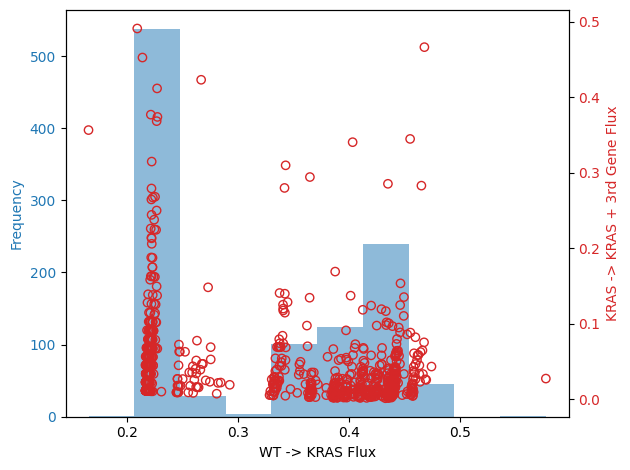

In [37]:
fluxes_mutant_KRAS = filter_to_xy((0,1,0), (0,1,1), all_fluxes)
fluxes_mutant_KRAS['TP53'] = flux_TP53
fluxes_mutant_KRAS['KRAS'] = flux_KRAS

KRAS_3rd_fluxes = dict()
for key in gene_fluxes_KRAS:
    KRAS_3rd_fluxes[key] = (gene_fluxes_KRAS[key], fluxes_mutant_KRAS[key])
    
#x for KRAS, y for 3rd gene
x = []
y = []
for i in KRAS_3rd_fluxes.values():
    x.append(i[0])
    y.append(i[1])

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel("WT -> KRAS Flux")
ax1.set_ylabel('Frequency', color=color)  # we already handled the x-label with ax1
ax1.hist(fluxes_KRAS, alpha = 0.5, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel("KRAS -> KRAS + 3rd Gene Flux", color=color)
ax2.scatter(x, y, color='none', edgecolor = color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [11]:
#comparison of high flux genes between the two modes
print(len([k for k,v in fluxes_mutant_KRAS.items() if k in KRAS_mode1_genes and v > 0.01]))
print(len([k for k,v in fluxes_mutant_KRAS.items() if k in KRAS_mode2_genes and v > 0.01]))

559
361


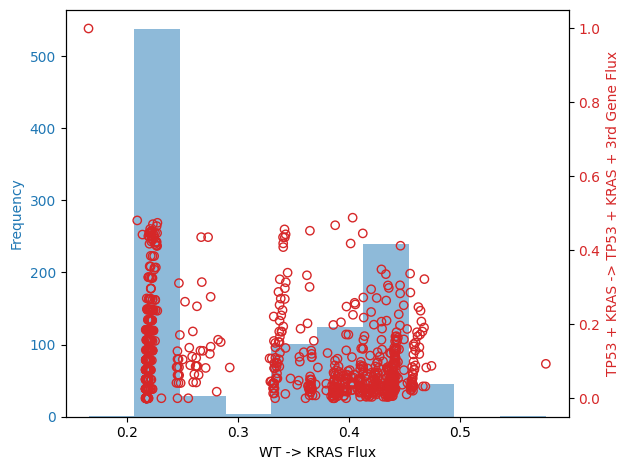

In [34]:
fluxes_mutant_KRAS = filter_to_xy((1,1,0), (1,1,1), all_fluxes)
fluxes_mutant_KRAS['TP53'] = flux_TP53
fluxes_mutant_KRAS['KRAS'] = flux_KRAS

KRAS_3rd_fluxes = dict()
for key in gene_fluxes_KRAS:
    KRAS_3rd_fluxes[key] = (gene_fluxes_KRAS[key], fluxes_mutant_KRAS[key])
    
#x for KRAS, y for 3rd gene
x = []
y = []
for i in KRAS_3rd_fluxes.values():
    x.append(i[0])
    y.append(i[1])

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel("WT -> KRAS Flux")
ax1.set_ylabel('Frequency', color=color)  # we already handled the x-label with ax1
ax1.hist(fluxes_KRAS, alpha = 0.5, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel("TP53 + KRAS -> TP53 + KRAS + 3rd Gene Flux", color=color)
ax2.scatter(x, y, color='none', edgecolor = color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [35]:
#comparison of high flux genes between the two modes
print(len([k for k,v in fluxes_mutant_KRAS.items() if k in KRAS_mode1_genes and v > 0.05]))
print(len([k for k,v in fluxes_mutant_KRAS.items() if k in KRAS_mode2_genes and v > 0.05]))

435
263


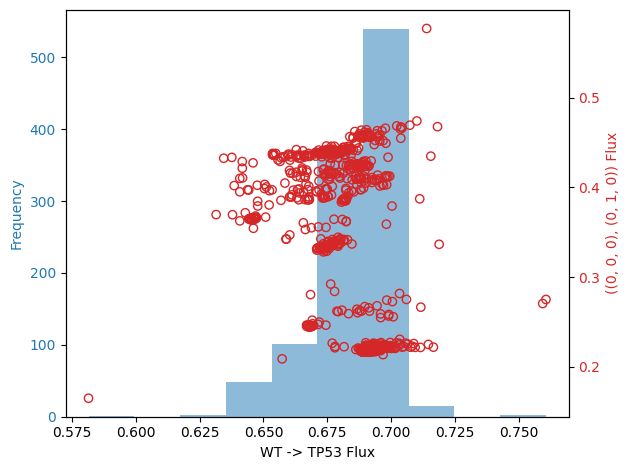

In [33]:
index = ((0,0,0), (0,1,0))

fluxes_mutant_TP53 = filter_to_xy(index[0], index[1], all_fluxes)
fluxes_mutant_TP53['TP53'] = flux_TP53
fluxes_mutant_TP53['KRAS'] = flux_KRAS

TP53_3rd_fluxes = dict()
for key in gene_fluxes_TP53:
    TP53_3rd_fluxes[key] = (gene_fluxes_TP53[key], fluxes_mutant_TP53[key])
    
#x for KRAS, y for 3rd gene
x = []
y = []
for i in TP53_3rd_fluxes.values():
    x.append(i[0])
    y.append(i[1])

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel("WT -> TP53 Flux")
ax1.set_ylabel('Frequency', color=color)  # we already handled the x-label with ax1
ax1.hist(fluxes_TP53, alpha = 0.5, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel(str(index) + " Flux", color=color)
ax2.scatter(x, y, color='none', edgecolor = color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

WT -> TP53 and KRAS fluxes seem to be mostly independent of each other, though a low KRAS flux may be linked to a higher TP53 flux, which we would expect to be the case if the 3rd gene aberration is acting through both the KRAS and TP53 fluxes.

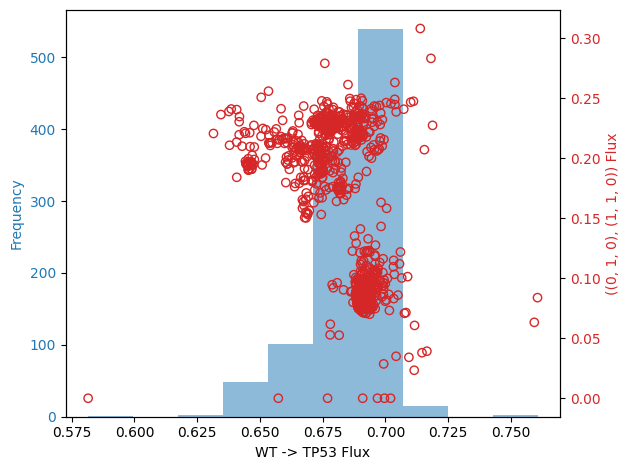

In [34]:
index = ((0,1,0), (1,1,0))

fluxes_mutant_TP53 = filter_to_xy(index[0], index[1], all_fluxes)
fluxes_mutant_TP53['TP53'] = flux_TP53
fluxes_mutant_TP53['KRAS'] = flux_KRAS

TP53_3rd_fluxes = dict()
for key in gene_fluxes_TP53:
    TP53_3rd_fluxes[key] = (gene_fluxes_TP53[key], fluxes_mutant_TP53[key])
    
#x for KRAS, y for 3rd gene
x = []
y = []
for i in TP53_3rd_fluxes.values():
    x.append(i[0])
    y.append(i[1])

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel("WT -> TP53 Flux")
ax1.set_ylabel('Frequency', color=color)  # we already handled the x-label with ax1
ax1.hist(fluxes_TP53, alpha = 0.5, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel(str(index)[1:-1].replace('), (',') -> (') + " Flux", color=color)
ax2.scatter(x, y, color='none', edgecolor = color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Bimodality featured strongly here as the genes responsible for the WT -> KRAS bimodal distribution seem to have further effects downstream, affecting even the distribution of the gain of TP53 post-KRAS mutation. This only occurs post-KRAS mutation, though the gain of TP53 post-KRAS+3rd-gene-mutation is very low for all 3rd genes, indicating no direct effect of the 3rd gene mutation. **ACTUALLY, THERE ARE SOME EXCEPTIONS TO THAT, I SHOULD CHECK IF THOSE EXCEPTIONS MATCH THE NON-ZERO FLUXES FOR (1,0,1), (1,1,1) AGAINST WT -> KRAS**

The genes that cause the low KRAS mode also cause a low TP53 mode **post-KRAS**, which may induce the high WT -> TP53 cluster. The opposite occurs for the high KRAS mode.

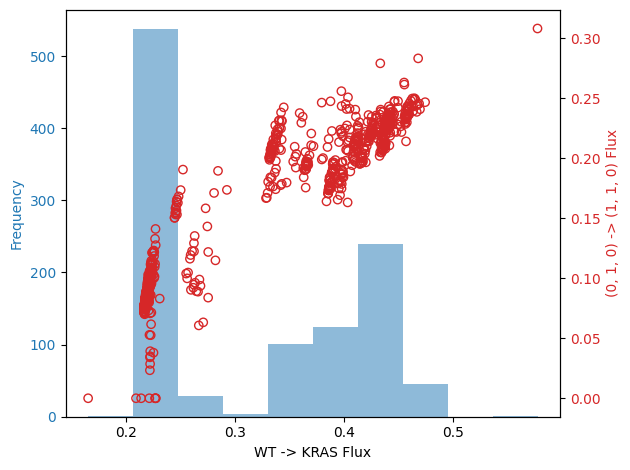

In [43]:
index = ((0,1,0), (1,1,0))

fluxes_mutant_KRAS = filter_to_xy(index[0], index[1], all_fluxes)
fluxes_mutant_KRAS['TP53'] = flux_TP53
fluxes_mutant_KRAS['KRAS'] = flux_KRAS

KRAS_3rd_fluxes = dict()
for key in gene_fluxes_KRAS:
    KRAS_3rd_fluxes[key] = (gene_fluxes_KRAS[key], fluxes_mutant_KRAS[key])
    
#x for KRAS, y for 3rd gene
x = []
y = []
for i in KRAS_3rd_fluxes.values():
    x.append(i[0])
    y.append(i[1])

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel("WT -> KRAS Flux")
ax1.set_ylabel('Frequency', color=color)  # we already handled the x-label with ax1
ax1.hist(fluxes_KRAS, alpha = 0.5, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel(str(index)[1:-1].replace('), (',') -> (') + " Flux", color=color)
ax2.scatter(x, y, color='none', edgecolor = color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Essentially just provides confirmation that the low mode for WT -> KRAS is strongly associated with the low mode of the gain of TP53 post-KRAS. The same is true for the high mode except it has less variability than the low mode.

## End of KRAS Section

## Gamma Analysis

In [5]:
from cancer_epistasis import compute_gammas

pan_data_mutation_rates_file = pd.read_csv('../output/pan_data_mutation_rates.txt')
pan_data_mutation_rates = dict(zip(pan_data_mutation_rates_file['gene'], pan_data_mutation_rates_file['rate']))

pan_data_fluxes_mles = np.load('../output/pan_data_fluxes_mles.npy', allow_pickle = True).item()\

pan_data_gammas = dict()
missing_mus = set()
for i in pan_data_fluxes_mles.keys():
    if i not in pan_data_mutation_rates.keys():
        missing_mus.add(i)
        continue
    genes3_ = ['TP53', 'KRAS', i]
    mus3_ = {(1, 0, 0): pan_data_mutation_rates[genes3_[0]],
            (0, 1, 0): pan_data_mutation_rates[genes3_[1]],
            (0, 0, 1): pan_data_mutation_rates[genes3_[2]]}
    pan_data_gammas[i] = compute_gammas(pan_data_fluxes_mles[i], mus3_)

pan_data_gammas = pd.DataFrame.from_dict(pan_data_gammas, orient = 'index')
#pan_data_gammas = pan_data_gammas.reset_index().rename(columns={'index':'gene'})
#pan_data_gammas = pan_data_gammas.set_index('gene')

In [106]:
smoking_mutation_rates_file = pd.read_csv('../output/smoking_mutation_rates.txt')
smoking_mutation_rates = dict(zip(smoking_mutation_rates_file['gene'], smoking_mutation_rates_file['rate']))

smoking_fluxes_mles = np.load('../output/smoking_fluxes_mles.npy', allow_pickle = True).item()\

smoking_gammas = dict()
missing_mus = set()
for i in smoking_fluxes_mles.keys():
    if i not in smoking_mutation_rates.keys():
        missing_mus.add(i)
        continue
    genes3_ = ['TP53', 'KRAS', i]
    mus3_ = {(1, 0, 0): smoking_mutation_rates[genes3_[0]],
            (0, 1, 0): smoking_mutation_rates[genes3_[1]],
            (0, 0, 1): smoking_mutation_rates[genes3_[2]]}
    smoking_gammas[i] = compute_gammas(smoking_fluxes_mles[i], mus3_)

smoking_gammas = pd.DataFrame.from_dict(smoking_gammas, orient = 'index')

#### Do the epistatic-incorporating gammas correlate with the cancereffectsizeR gammas?
We don't expect perfect correlations because of the inherent difference in methodology, but we hope to observe a rough correlation.

In [10]:
#Making gammas into ratios for comparison with CES
gamma_ratios = pan_data_gammas[((0, 0, 0), (0, 0, 1))]/pan_data_gammas[((0, 0, 0), (0, 1, 0))]
gamma_ratios = gamma_ratios.reset_index().rename(columns = {'index':'gene', 0:'gamma'})

In [11]:
#Ratio from CES for comparison
sis = pd.read_csv('../temp/ratioed_selections.txt')
sis = sis.rename(columns={'rn':'gene', 'gene_selection/gene_selection["KRAS"]':'si'})

In [12]:
comparison_df = pd.merge(gamma_ratios, sis, on = 'gene')

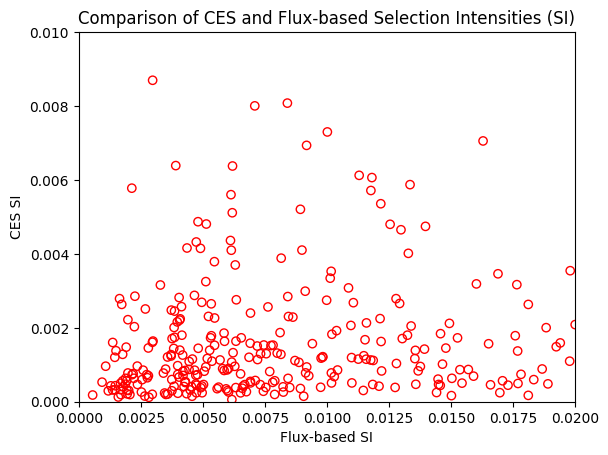

In [26]:
fig, ax = plt.subplots()

ax.scatter(comparison_df['gamma'], comparison_df['si'], color = 'none', edgecolor = 'red')

ax.set_xlabel('Flux-based SI')
ax.set_ylabel('CES SI')
plt.title('Comparison of CES and Flux-based Selection Intensities (SI)')

ax.set_xlim(0,0.02)
ax.set_ylim(0,0.010)

plt.show()

In [39]:
#Correlation
comparison_df['gamma'].corr(comparison_df['si'])

0.24543505044103617

##### Determining Highest Flux and Gamma Genes

In [6]:
patients_per_gene = pd.read_csv(location_output + '/patients_per_gene.csv', index_col = 0).rename(columns={'0':'num_patients'})

In [7]:
fluxes = pd.DataFrame.from_dict(fluxes, orient='index').reset_index().rename(columns={'index':'gene', 0:'flux'})
gammas_from_WT = pan_data_gammas[((0, 0, 0), (0, 0, 1))].reset_index().rename(columns={'index':'gene'})

In [8]:
flux_gamma = pd.merge(gammas_from_WT, fluxes, on='gene')
flux_gamma = pd.merge(flux_gamma, patients_per_gene, left_on='gene', right_index=True)

/Users/Krishna1/opt/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


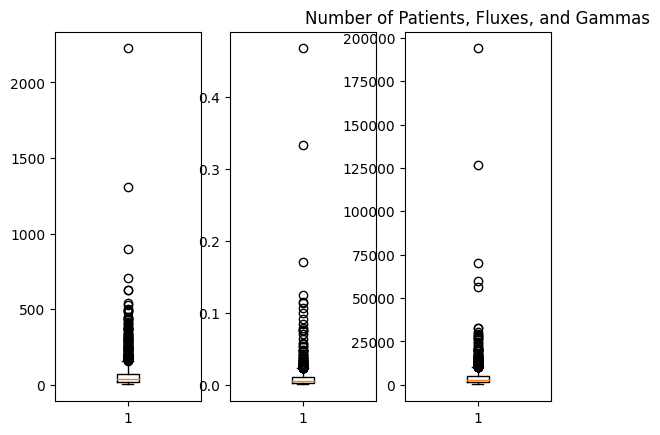

In [9]:
fig, axs = plt.subplots(1, 3)

axs[0].boxplot(flux_gamma['num_patients'])
axs[1].boxplot(flux_gamma['flux'])
axs[2].boxplot(flux_gamma[((0,0,0),(0,0,1))])

plt.title("Number of Patients, Fluxes, and Gammas")

plt.show()

In [11]:
flux_gamma.sort_values(by = 'num_patients', ascending=False)

,gene,"(gene, )","((0, 0, 0), (0, 0, 1))",flux,num_patients
0,EGFR,EGFR,126662.421613,0.334073,2224
6,STK11,STK11,29276.486612,0.078674,1306
9,KEAP1,KEAP1,30489.727294,0.048728,901
15,ATM,ATM,32488.137789,0.031462,709
8,LRP1B,LRP1B,10149.232459,0.074387,629
...,...,...,...,...,...
289,EXOSC9,EXOSC9,1296.141191,0.001339,5
178,DDX47,DDX47,2666.873817,0.002680,5
205,NAA60,NAA60,1239.249219,0.001339,4
306,TMEM65,TMEM65,705.421874,0.001339,4


In [18]:
flux_gamma.sort_values(by = 'flux', ascending=False)

,gene,"(gene, )","((0, 0, 0), (0, 0, 1))",flux,num_patients
590,TTN,TTN,193855.970080,0.467993,494
0,EGFR,EGFR,126662.421613,0.334073,2224
90,ZFHX4,ZFHX4,16944.500873,0.170979,291
414,RYR2,RYR2,8933.443164,0.124169,373
659,SPTA1,SPTA1,11747.596059,0.114615,283
...,...,...,...,...,...
898,MSI2,MSI2,162.879491,0.000519,16
946,PPP6C,PPP6C,561.016030,0.000427,17
744,BCL10,BCL10,485.786797,0.000408,13
978,RPS6KB2,RPS6KB2,468.589143,0.000393,15


In [19]:
flux_ranks = flux_gamma.sort_values(by = 'flux', ascending=False)['gene'].to_list()
flux_gamma['flux_rank'] = [flux_ranks.index(gene) for gene in flux_gamma['gene']]

In [91]:
flux_gamma.sort_values(by = ((0,0,0),(0,0,1)), ascending=False)

,gene,"(gene, )","((0, 0, 0), (0, 0, 1))",flux,num_patients
590,TTN,TTN,193855.970080,0.467993,494
0,EGFR,EGFR,126662.421613,0.334073,2224
23,CTNNB1,CTNNB1,70043.590931,0.032352,303
2,BRAF,BRAF,60074.827919,0.047305,526
24,SETD2,SETD2,56488.187982,0.041818,441
...,...,...,...,...,...
208,OR8B2,OR8B2,199.761259,0.001337,12
987,SDHD,SDHD,192.034290,0.000565,14
937,PIM1,PIM1,187.200065,0.000553,16
898,MSI2,MSI2,162.879491,0.000519,16


In [34]:
gamma_ranks = flux_gamma.sort_values(by = ((0,0,0),(0,0,1)), ascending=False)['gene'].to_list()
flux_gamma['gamma_rank'] = [gamma_ranks.index(gene) for gene in flux_gamma['gene']]

In [33]:
flux_gamma.sort_values(by = 'num_patients', ascending=False).head(21).sort_values(by = 'flux', ascending=False)

,gene,"(gene, )","((0, 0, 0), (0, 0, 1))",flux,num_patients,flux_rank
590,TTN,TTN,193855.970080,0.467993,494,0
0,EGFR,EGFR,126662.421613,0.334073,2224,1
6,STK11,STK11,29276.486612,0.078674,1306,10
8,LRP1B,LRP1B,10149.232459,0.074387,629,13
18,RBM10,RBM10,32666.143934,0.064262,541,15
9,KEAP1,KEAP1,30489.727294,0.048728,901,20
2,BRAF,BRAF,60074.827919,0.047305,526,23
24,SETD2,SETD2,56488.187982,0.041818,441,27
5,MET,MET,17863.085382,0.040481,408,28
10,NF1,NF1,15505.953063,0.033545,626,34


In [35]:
flux_gamma.sort_values(by = 'num_patients', ascending=False).head(21).sort_values(by = ((0,0,0),(0,0,1)), ascending=False)

,gene,"(gene, )","((0, 0, 0), (0, 0, 1))",flux,num_patients,flux_rank,gamma_rank
590,TTN,TTN,193855.970080,0.467993,494,0,0
0,EGFR,EGFR,126662.421613,0.334073,2224,1,1
2,BRAF,BRAF,60074.827919,0.047305,526,23,3
24,SETD2,SETD2,56488.187982,0.041818,441,27,4
18,RBM10,RBM10,32666.143934,0.064262,541,15,5
15,ATM,ATM,32488.137789,0.031462,709,40,6
9,KEAP1,KEAP1,30489.727294,0.048728,901,20,7
6,STK11,STK11,29276.486612,0.078674,1306,10,8
35,ARID1A,ARID1A,28298.147920,0.026164,479,56,10
3,PIK3CA,PIK3CA,26368.146111,0.032895,494,35,13


## UNDERSTAND TTN HIGH GAMMA

#### Objectives:
1. Determine if TTN and similarly large genes have high gammas in every level of the flux map
2. Figure out if TTN and similarly large genes have high average fluxes relative to other fluxes in the map
3. Determine if those fluxes have high variance or are consistently high
4. Determine whether the gammas can be accounted for by the mutation rates

### Objective 1: Gamma Comparison

In [8]:
gamma_ranks = pd.DataFrame(columns = pan_data_gammas.columns)
for col in pan_data_gammas.columns:
    gamma_ranks[col] = pan_data_gammas.sort_values(by = col, ascending = False).index

In [9]:
[gamma_ranks[gamma_ranks[col] == 'TTN'].index.values for col in pan_data_gammas.columns]

[array([0]),
 array([1037]),
 array([0]),
 array([5]),
 array([1037]),
 array([0]),
 array([0]),
 array([1031]),
 array([1036]),
 array([0]),
 array([20]),
 array([1])]

HIGH GAMMAS:
TTN is in the top 6 gammas of all 3rd genes for every gain of mutation in 3rd gene.
    WT -> TTN
    KRAS -> TTN + KRAS
    TP53 -> TTN + TP53
    KRAS + TP53 -> TTN + KRAS + TP53
In the non-gain-of-TTN changes, the gammas for those mutations are also high in their category:
    TTN -> TTN + KRAS
    TTN -> TTN + TP53
    TTN + KRAS -> TTN + KRAS + TP53
    TTN + TP53 -> TTN + KRAS + TP53
    
LOW GAMMAS:
The changes that have low gammas are when TTN isn't involved (TTN isn't mutated prior to or during the state change)
which makes sense based on the high probability of TTN mutation from any state; any state that does not involve
TTN is highly unlikely.
    WT -> KRAS
    WT -> TP53
    KRAS -> KRAS + TP53
    TP53 -> KRAS + TP53
    
OTHER GENES:
Upon a very preliminary look, the other genes didn't seem to follow the same pattern.

In [11]:
gain_of_3rd_gammas = pan_data_gammas.iloc[:,[0,3,6,11]].transpose()
with_3rd_gammas = pan_data_gammas.iloc[:,[2,5,9,10]].transpose()
no_3rd_gammas = pan_data_gammas.iloc[:,[1,4,7,8]].transpose()

In [12]:
#gain_of_3rd = [((0, 0, 0), (0, 0, 1)),((0, 1, 0), (0, 1, 1)),((1, 0, 0), (1, 0, 1)),((1, 1, 0), (1, 1, 1))]
large_genes = ['TTN','PTPRD','CNTNAP2','CSMD1','LRP1B']
small_or_influential_genes = ['EGFR','APC','NFE2L2','RB1','BRAF','NF1']

In [16]:
print(gain_of_3rd_gammas[large_genes + small_or_influential_genes])

print(with_3rd_gammas[large_genes + small_or_influential_genes])

print(no_3rd_gammas[large_genes + small_or_influential_genes])

                               TTN         PTPRD       CNTNAP2         CSMD1  \
(0, 0, 0) (0, 0, 1)  193855.970080   2799.938723   2503.664616   5149.850387   
(0, 1, 0) (0, 1, 1)  147624.144537  18188.052063  13668.455214  19588.412779   
(1, 0, 0) (1, 0, 1)  414227.991427  23717.469511  21504.336686  24634.602201   
(1, 1, 0) (1, 1, 1)  414227.991427  48946.396877  46634.314599  59862.129054   

                            LRP1B           EGFR            APC        NFE2L2  \
(0, 0, 0) (0, 0, 1)  10149.232459  126662.421613   26133.590909   7718.234959   
(0, 1, 0) (0, 1, 1)  46436.170638   10267.925680   68675.953723  32526.096232   
(1, 0, 0) (1, 0, 1)  56662.556256  184644.213469  107581.236742  34646.350441   
(1, 1, 0) (1, 1, 1)  66622.131242   35276.548542  192251.483079  54554.162135   

                               RB1           BRAF            NF1  
(0, 0, 0) (0, 0, 1)    8553.272094   60074.827919   15505.953063  
(0, 1, 0) (0, 1, 1)   16080.827723   54627.606305   40688.2

### Objective 2: Average Flux Comparison

In [17]:
all_fluxes_df = pd.DataFrame.from_dict(all_fluxes, orient = 'index')

In [18]:
gain_of_3rd = all_fluxes_df.iloc[:,[0,3,6,11]].transpose()
with_3rd = all_fluxes_df.iloc[:,[2,5,9,10]].transpose()
no_3rd = all_fluxes_df.iloc[:,[1,4,7,9]].transpose()

In [19]:
third_v_with_third_flux = abs(gain_of_3rd.describe().loc['mean'] - with_3rd.describe().loc['mean'])/(abs((gain_of_3rd.describe().loc['std'] - with_3rd.describe().loc['std']))**(1/2))
print(third_v_with_third_flux.sort_values(ascending=False))
#as expected, the fluxes to TTN mutation and fluxes from states with TTN mutation are approximately equivalent
#this indicates that TTN itself shouldn't have a high gamma, just that it its mutation is extremely likely to be acquired

third_v_no_third_flux = abs(gain_of_3rd.describe().loc['mean'] - no_3rd.describe().loc['mean'])/(abs((gain_of_3rd.describe().loc['std'] - no_3rd.describe().loc['std']))**(1/2))
print(third_v_no_third_flux.sort_values(ascending=False))
#flux to TTN mutation much higher than fluxes not coming from or going to a state involving TTN mutation
#again indicates that TTN is very likely to be present in any mutational state

with_third_v_no_third_flux = abs(with_3rd.describe().loc['mean'] - no_3rd.describe().loc['mean'])/(abs((with_3rd.describe().loc['std'] - no_3rd.describe().loc['std']))**(1/2))
print(with_third_v_no_third_flux.sort_values(ascending=False))
'''
TTN is second for genes which have fluxes coming from a state with mutation of that gene
It is below USH2A (?), and EGFR, which I believe is due to EGFR being a frequent mutation in LUAD
Q: Why I am not seeing other frequently mutated genes more commonly in these analyses which should
feature the most frequently mutated genes?
'''

PXDNL     1.469315
STK11     0.935070
ADGRL3    0.841433
ZFHX4     0.829290
ASTN1     0.808196
            ...   
SPTA1     0.056824
STK40     0.055219
EGFL7     0.053826
RAB35     0.045119
CSMD3     0.035512
Length: 1082, dtype: float64
TTN       0.828267
FAT3      0.760139
GNAQ      0.630890
NPM1      0.625917
HRAS      0.625626
            ...   
ERICH3    0.040074
ADGRL3    0.038756
NAV3      0.038408
ASTN1     0.033396
ANK2      0.010975
Length: 1082, dtype: float64
USH2A      2.520139
TTN        1.060714
EGFR       1.052377
ZFHX4      0.937066
ANK2       0.892922
             ...   
CSMD3      0.161527
NAV3       0.100830
SI         0.080162
RYR2       0.030656
COL11A1    0.024882
Length: 1082, dtype: float64


'\nTTN is second for genes which have fluxes coming from a state with mutation of thaat gene\nIt is below USH2A (?), and EGFR, which I believe is due to EGFR being a frequent mutation in LUAD\nQ: Why I am not seeing other frequently mutated genes more commonly in these analyses which should\nfeature the most frequently mutated genes?\n'

### Objective 3: Flux Variances

In [21]:
gain_of_3rd[large_genes + small_or_influential_genes].describe()
#variability in fluxes of large genes generally seems to be larger than that of small genes
#however this may be attributable to the difference in mean fluxes

with_3rd[large_genes + small_or_influential_genes].describe()
#Only TTN, EGFR, and LRP1B have significant variance because they are also the only ones with non~0 fluxes
#Why are the fluxes for the other large genes not higher? Are they not mutated as frequently?
#  Will need to check with mutation rates.

no_3rd[large_genes + small_or_influential_genes].describe()
#as expected, variability and fluxes here are approximately the same
#since the 3rd gene has no influence for these fluxes

,TTN,PTPRD,CNTNAP2,CSMD1,LRP1B,EGFR,APC,NFE2L2,RB1,BRAF,NF1
count,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
mean,4.366204e-01,3.422101e-01,3.124868e-01,3.308939e-01,0.500959,3.998708e-01,3.519799e-01,3.366458e-01,3.503093e-01,3.577751e-01,3.504437e-01
std,4.482687e-01,2.871322e-01,2.819115e-01,2.837393e-01,0.270376,3.153604e-01,2.989368e-01,2.910734e-01,2.944762e-01,3.043932e-01,2.907861e-01
min,9.729103e-19,7.418190e-35,4.377263e-21,5.754365e-32,0.163293,2.896639e-32,1.325184e-34,1.553649e-29,2.502522e-20,9.923569e-29,3.147862e-26
25%,1.237157e-01,1.859780e-01,1.737488e-01,1.840219e-01,0.343106,2.312547e-01,1.831161e-01,1.699223e-01,1.867592e-01,1.851635e-01,1.961668e-01
50%,3.732409e-01,3.470825e-01,2.860703e-01,3.233027e-01,0.550659,4.427800e-01,3.550711e-01,3.331413e-01,3.564409e-01,3.605024e-01,3.583308e-01
75%,6.861456e-01,5.033146e-01,4.248083e-01,4.701746e-01,0.708512,6.113961e-01,5.239348e-01,4.998648e-01,5.199910e-01,5.331140e-01,5.126077e-01
max,1.000000e+00,6.746755e-01,6.778068e-01,6.769700e-01,0.739224,7.139234e-01,6.977773e-01,6.803004e-01,6.883553e-01,7.100957e-01,6.851132e-01


### Objective 4: Explanatory Ability of Mutation Rates

In [41]:
[pan_data_mutation_rates.get(key) for key in large_genes + small_or_influential_genes]

[2.41412946661321e-06,
 8.42615286384648e-06,
 8.76388307156245e-06,
 6.99121251529511e-06,
 7.32929650373105e-06,
 2.63750941126879e-06,
 9.38503042837861e-07,
 1.00851064219141e-06,
 1.41728188416379e-06,
 7.87428177823334e-07,
 2.16337781160238e-06]

In [42]:
pan_data_mutation_rates.get('TTN')

2.41412946661321e-06

In [63]:
#PTPRD mutation rate used as an estimate of what TTN's expected mutation rate is.
mus3_PTPRD = {(1, 0, 0): pan_data_mutation_rates['TP53'],
            (0, 1, 0): pan_data_mutation_rates['KRAS'],
            (0, 0, 1): pan_data_mutation_rates['PTPRD']}
TTN_updated_gammas = compute_gammas(pan_data_fluxes_mles['TTN'], mus3_PTPRD)
print(TTN_updated_gammas)

{((0, 0, 0), (0, 0, 1)): 55540.57910071084, ((0, 0, 0), (0, 1, 0)): 162955.7381855744, ((0, 0, 1), (0, 1, 1)): 727788.1384427464, ((0, 1, 0), (0, 1, 1)): 42294.9598790576, ((0, 0, 0), (1, 0, 0)): 230982.3844507643, ((0, 0, 1), (1, 0, 1)): 397199.4299082104, ((1, 0, 0), (1, 0, 1)): 118678.12228883621, ((0, 1, 0), (1, 1, 0)): 3.864393980775746e-13, ((1, 0, 0), (1, 1, 0)): 356287.8469960599, ((0, 1, 1), (1, 1, 1)): 397199.4299082104, ((1, 0, 1), (1, 1, 1)): 219664.08089099597, ((1, 1, 0), (1, 1, 1)): 118678.12228883621}


In [64]:
pan_data_gammas.describe()

(0, 0, 0)                    (0, 0, 1)      (0, 1, 0)  \
           (0, 0, 1)      (0, 1, 0)     (0, 1, 1)      (0, 1, 1)   
count    1038.000000    1038.000000  1.038000e+03    1038.000000   
mean     4640.628722  310451.853108  1.750596e+03   18423.324176   
std      8937.822969   96836.303666  2.876886e+04   23080.219839   
min       141.508309  162955.738186  2.864041e-39     409.482947   
25%      1441.171497  215717.169795  1.695097e-28    6015.235187   
50%      2731.428124  264313.774472  8.085982e-27   11689.734757   
75%      4885.260549  413088.597800  6.408827e-24   21239.242189   
max    193855.970080  570227.047256  7.277881e+05  291971.661772   

           (0, 0, 0)     (0, 0, 1)      (1, 0, 0)     (0, 1, 0)  \
           (1, 0, 0)     (1, 0, 1)      (1, 0, 1)     (1, 1, 0)   
count    1038.000000  1.038000e+03    1038.000000  1.038000e+03   
mean   271358.452733  4.001164e+03   26096.695221  5.976661e+04   
std      5494.658318  3.281765e+04   27047.424178  2.659370e+04   
min    230982.384451  1.041689e-38     634.857487  1.045514e-25   
25%    268509.772015  8.705699e-24    9822.975031  3.330537e+04   
50%    273670.173773  1.863312e-21   18247.337048  6.499226e+04   
75%    274565.038454  2.780992e-18   32571.072379  8.619391e+04   
max    285515.444898  3.971994e+05  414227.991427  1.224723e+05   

           (1, 0, 0)     (0, 1, 1)     (1, 0, 1)     (1, 1, 0)  
           (1, 1, 0)     (1, 1, 1)     (1, 1, 1)     (1, 1, 1)  
count    1038.000000  1.038000e+03  1.038000e+03  1.038000e+03  
mean   396763.778891  3.061682e+03  8.959214e+03  4.744975e+04  
std     10857.514792  2.590907e+04  5.260720e+04  4.973428e+04  
min    329129.966000  1.298454e-35  6.707987e-37  1.053903e-31  
25%    386064.332001  5.377985e-26  2.152521e-25  1.716439e+04  
50%    398363.583298  2.403055e-22  4.622879e-22  3.372756e+04  
75%    406292.717551  6.387656e-18  1.752882e-17  6.120306e+04  
max    444656.476954  3.971994e+05  4.914853e+05  5.705210e+05

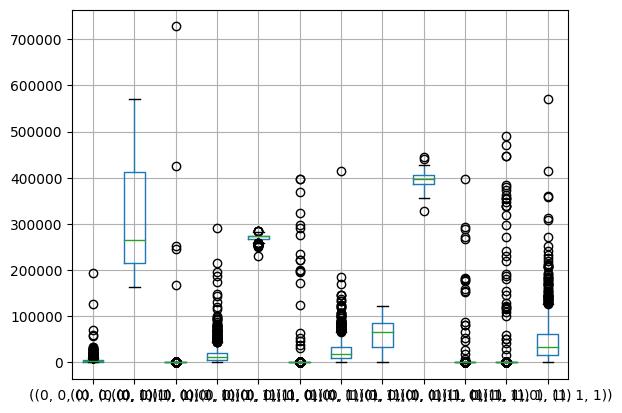

In [59]:
boxplot = pan_data_gammas.boxplot()
plt.show()

**The reason for the high gammas is that mutation rate is abnormally low for such a large gene.**

Interestingly, the TTN as 3rd gene gamma is the highest gamma for the following state changes:
    TTN -> TTN + KRAS
    TTN -> TTN + TP53
    TTN + KRAS -> TTN + KRAS + TP53
        Not TTN + TP53 -> TTN + KRAS + TP53
It makes sense for these gammas to be high as they involve the gain of KRAS and TP53.
However, TTN as the 3rd gene is the amongst the lowest gammas for the following state changes:
    WT -> KRAS
    WT -> TP53
    KRAS -> KRAS + TP53
    TP53 -> KRAS + TP53
**Considering that TTN should have no effect, the gammas for KRAS and TP53 with TTN mutation shouldn't be so drastically different.**